<a href="https://colab.research.google.com/github/yhc-666/hate-speech-detection/blob/master/randomforest_with_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 20 17:50:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
df_dataset = pd.read_csv('/content/drive/MyDrive/50.007kaggle/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/50.007kaggle/test.csv')
df_dataset_features = pd.read_csv("/content/drive/MyDrive/50.007kaggle/train_tfidf_features.csv")
df_test_features = pd.read_csv("/content/drive/MyDrive/50.007kaggle/test_tfidf_features.csv")
samplesubmit = pd.read_csv("/content/drive/MyDrive/50.007kaggle/sample_submission.csv")

In [ ]:
print(samplesubmit.shape)

(4296, 2)


In [5]:
y = df_dataset_features.iloc[:,[1]]
X = df_dataset_features.iloc[:,2:]

## STEP1: Use cross validation to find optimum hyper parameters

In [8]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
cnt = 1
for train_index, validation_index in cv.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Validation set:{len(validation_index)}')
    cnt += 1

Fold:1, Train set: 15465, Validation set:1719
Fold:2, Train set: 15465, Validation set:1719
Fold:3, Train set: 15465, Validation set:1719
Fold:4, Train set: 15465, Validation set:1719
Fold:5, Train set: 15466, Validation set:1718
Fold:6, Train set: 15466, Validation set:1718
Fold:7, Train set: 15466, Validation set:1718
Fold:8, Train set: 15466, Validation set:1718
Fold:9, Train set: 15466, Validation set:1718
Fold:10, Train set: 15466, Validation set:1718


In [ ]:
def my_custom_loss_func(y_true, y_pred):
    pos_f1 = metrics.f1_score(y_validation, y_pred_validation, pos_label=1 )
    neg_f1 = metrics.f1_score(y_validation, y_pred_validation, pos_label=0 )
    macro_f1 = (pos_f1 + neg_f1)/2  
    return macro_f1

macro_f1 = make_scorer(my_custom_loss_func, greater_is_better=True)

In [ ]:
model = RandomForestClassifier(n_estimators=100, 
                               #max_depth = 1000, 
                               min_samples_split = 5,
                               #max_leaf_nodes = 800,##
                               class_weight = {0:1, 1:2},
                               random_state = 4)

### 首先调n_estimators

In [ ]:
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(20,201,10):
    model = RandomForestClassifier(n_estimators=i, 
                               #max_depth = 1000, 
                               min_samples_split = 5,
                               #max_leaf_nodes = 800,##
                               class_weight = {0:1, 1:2},
                               random_state = 4)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1_macro", verbose = 2).mean()
    score_lt.append(score)

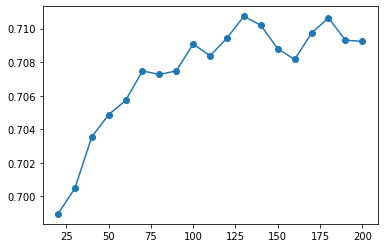

In [ ]:
x = np.arange(20, 201, 10)
plt.subplot(111)
plt.plot(x, score_lt,'o-')
plt.show()

In [ ]:
score_max = max(score_lt)
print('highest macro f1 score：{}'.format(score_max),
      'num_estimators：{}'.format(score_lt.index(score_max)*10+21))

highest macro f1 score：0.7107317680382209 num_estimators：131


### 再调 min samples split

In [ ]:
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(2,13,1):
    model = RandomForestClassifier(n_estimators= 131, 
                               #max_depth = 1000, 
                               min_samples_split = i,
                               #max_leaf_nodes = 800,##
                               class_weight = {0:1, 1:2},
                               random_state = 4)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1_macro", verbose = 2).mean()
    score_lt.append(score)

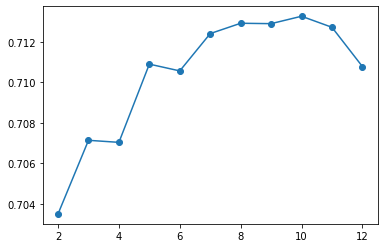

In [ ]:
x = np.arange(2, 13, 1)
plt.subplot(111)
plt.plot(x, score_lt,'o-')
plt.show()

In [ ]:
score_max = max(score_lt)
print('highest macro f1 score：{}'.format(score_max),
      'best_min_sample_split：{}'.format(score_lt.index(score_max)*1+2))

highest macro f1 score：0.7132696428050758 best_min_sample_split：10


### 调class weight

In [ ]:
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in np.arange(1.2, 2.85, 0.05):
    model = RandomForestClassifier(n_estimators= 131, 
                               #max_depth = 1000, 
                               min_samples_split = 5,
                               #max_leaf_nodes = 800,##
                               class_weight = {0:1, 1:i},
                               random_state = 4)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1_macro", verbose = 2).mean()
    score_lt.append(score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .................................................... total time= 1.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .................................................... total time= 1.3min


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [ ]:
x = np.arange(1.2, 2.85, 0.05)
plt.subplot(111)
plt.plot(x, score_lt,'o-')
plt.show()

In [ ]:
score_max = max(score_lt)
print('highest macro f1 score：{}'.format(score_max),
      'best_class_weight：{}'.format(score_lt.index(score_max) * 0.05 + 1.2))

## 2. Train the fine tuned model on the whole dataset to get our final model

In [ ]:
final_model = RandomForestClassifier(n_estimators=131, 
                               #max_depth = 1000, 
                               min_samples_split = 10,
                               #max_leaf_nodes = 800,##
                               class_weight = {0:1, 1:2},
                               random_state = 4)

In [ ]:
final_model.fit(X,y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(class_weight={0: 1, 1: 2}, min_samples_split=10,
                       n_estimators=131, random_state=4)

In [ ]:
y, y_pred = y, final_model.predict(X)

threshold = 0.5
for i in range(len(y_pred)):
    y_pred[i] = 1 if y_pred[i] > threshold else 0
pos_f1 = metrics.f1_score(y, y_pred, pos_label=1 )
neg_f1 = metrics.f1_score(y, y_pred, pos_label=0 )
macro_f1 = (pos_f1 + neg_f1)/2
print(pos_f1)
print(neg_f1)
print("macro_f1 : %.4g" % macro_f1)  
print("acc: %.4g"% metrics.accuracy_score(y, y_pred))

0.9887708649468893
0.9930149141023221
macro_f1 : 0.9909
acc: 0.9914


In [ ]:
X_test = df_test_features.iloc[:,1:]

In [ ]:
y_test = final_model.predict(X_test)

In [ ]:
print(y_test)

[1 0 1 ... 1 0 0]


In [ ]:
x = df_test
x = x.set_index("id")
x = x.drop("post", axis = 1)
x["label"] = y_test
print(x)
x.to_csv("/content/drive/MyDrive/50.007kaggle/submit.csv")

       label
id          
17185      1
17186      0
17187      1
17188      0
17189      0
...      ...
21476      1
21477      1
21478      1
21479      0
21480      0

[4296 rows x 1 columns]
